### New loss test to use Bradley-Terry model


In [1]:
import os

os.chdir("/home/adamczykb/rnaquanet/src")
os.environ['MLFLOW_TRACKING_USERNAME']='admin'
os.environ['MLFLOW_TRACKING_PASSWORD']='TI5du9by'


In [2]:
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDatasetTuplet
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDatasetSubset

from torch_geometric import nn as gnn
import lightning as L
from torch_geometric.loader import DataLoader


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RNAQuANet(L.LightningModule):
    def __init__(self, number_of_node_features: int):
        super().__init__()
        self.save_hyperparameters()
        self.norm1 = gnn.BatchNorm(number_of_node_features)

        self.GATconv1 = gnn.GATv2Conv(
            number_of_node_features, number_of_node_features, heads=4, edge_dim=36
        )

        self.GATconv2 = gnn.GATv2Conv(
            number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=36
        )
        self.GATconv3 = gnn.GATv2Conv(
            number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=36
        )

        self.GCN2Conv1 = gnn.GeneralConv(
            number_of_node_features * 4, number_of_node_features, in_edge_channels=36
        )

        self.fc1 = nn.Linear(number_of_node_features, number_of_node_features)
        self.fc3 = nn.Linear(number_of_node_features, 1)
        self.dropout = nn.Dropout(0.3)
        self.activation = nn.LeakyReLU()
        self.activationlast = nn.ReLU()
        self.aggregation = gnn.aggr.SetTransformerAggregation(
            number_of_node_features, dropout=0.3, layer_norm=True
        )

    def forward(self, x, edge_index, edge_attr, batch):

        y = self.norm1(x)
        y = self.GATconv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv2(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv3(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GCN2Conv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)

        y = self.aggregation(y, batch)

        y = self.fc1(y)
        y = self.activation(y)
        y = self.dropout(y)

        y = self.fc3(y)

        return self.activationlast(y)

    def training_step(self, data, batch_idx):
        s1, s2 = data
        result_1 = self.forward(s1.x, s1.edge_index, s1.edge_attr, s1.batch)
        result_2 = self.forward(s2.x, s2.edge_index, s2.edge_attr, s2.batch)

        loss_mae_s1 = (torch.abs(result_1 - s1.y.unsqueeze(-1))).mean()
        loss_mae_s2 = (torch.abs(result_2 - s2.y.unsqueeze(-1))).mean()
        loss_mse_s1 = (torch.square(torch.abs(result_1 - s1.y.unsqueeze(-1)))).mean()
        loss_mse_s2 = (torch.square(torch.abs(result_2 - s2.y.unsqueeze(-1)))).mean()

        self.log("train_loss_mae", (loss_mae_s1 + loss_mae_s2) / 2)
        self.log("train_loss_mse", (loss_mse_s1 + loss_mse_s2) / 2)
        loss = (loss_mae_s1 + loss_mae_s2) / 2
        result_1=result_1[0]
        result_2=result_2[0]
        if s1.y[0] < s2.y[0]:
            if result_1 > result_2:
                loss = loss + 1
        else:
            if result_1 < result_2:
                loss= loss + 1
        self.log("train_loss_mod", loss, batch_size=125)
        return loss

    def validation_step(self, data, batch_idx):
        s1, s2 = data
        result_1 = self.forward(s1.x, s1.edge_index, s1.edge_attr, s1.batch)
        result_2 = self.forward(s2.x, s2.edge_index, s2.edge_attr, s2.batch)

        loss_mae_s1 = (torch.abs(result_1 - s1.y.unsqueeze(-1))).mean()
        loss_mae_s2 = (torch.abs(result_2 - s2.y.unsqueeze(-1))).mean()
        loss_mse_s1 = (torch.square(torch.abs(result_1 - s1.y.unsqueeze(-1)))).mean()
        loss_mse_s2 = (torch.square(torch.abs(result_2 - s2.y.unsqueeze(-1)))).mean()

        self.log("val_loss_mae", (loss_mae_s1 + loss_mae_s2) / 2)
        self.log("val_loss_mse", (loss_mse_s1 + loss_mse_s2) / 2)

        loss = (loss_mae_s1 + loss_mae_s2) / 2
        result_1=result_1[0]
        result_2=result_2[0]
        if s1.y[0] < s2.y[0]:
            if result_1 > result_2:
                loss = loss + 1
        else:
            if result_1 < result_2:
                loss= loss + 1
        self.log("val_loss_mod", loss, batch_size=125)
        return loss

    def backward(self, loss):
        loss.backward()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [13]:
CUTOFF=15.0
SUBSETS=[RNAQuANetDatasetSubset.ALL]

In [14]:
import enum


class DATASET(enum.Enum):
    RNAQUANET = {'name':'rnaquanet','path':'rnaquanet_structures','size_of_common_identifier':3}
    ARES = {'name':'ares','path':'ares'}
    LOCIPARSE = {'name':'lociparse','path':'lociparse_structures','size_of_common_identifier':2}
    DECOY = {'name':'randstr_decoy','path':'randstr_decoy'}
    COMBINED = {'name':'combined','path':'combined'}

dataset_dec_train = DATASET.LOCIPARSE
dataset_dec_val = DATASET.LOCIPARSE

```Error loading 1jidB_M223.pt: Ran out of input
Error loading 1y699_M272.pt: Ran out of input
Error loading 1xokA_M120.pt: Ran out of input
Error loading 1ze2D_M79.pt: Ran out of input
Error loading 3f1gZ_M97.pt: Ran out of input
Error loading 2quxR_M241.pt: Ran out of input
Error loading 3eogA_M482.pt: Ran out of input
Error loading 1fg0A_M260.pt: Ran out of input
Error loading 3gcaA_M424.pt: Ran out of input
Error loading 2il9M_M373.pt: Ran out of input
Error loading 2dr2B_M498.pt: Ran out of input
Error loading 1y699_M271.pt: Ran out of input
Error loading 2nz4S_M438.pt: Ran out of input
Error loading 1jidB_M222.pt: Ran out of input
Error loading 2il9M_M374.pt: Ran out of input
Error loading 2quxR_M240.pt: Ran out of input
Error loading 1et4E_M441.pt: Ran out of input

In [6]:
dataset_train = RNAQuANetDatasetTuplet(
    f"/home/adamczykb/rnaquanet/data/06_model_input/{dataset_dec_train.value['path']}/train",
    size_of_common_identifier=dataset_dec_train.value['size_of_common_identifier']
    # subsets=SUBSETS,
    # cutoff=CUTOFF,
)
dataset_val = RNAQuANetDatasetTuplet(
    f"/home/adamczykb/rnaquanet/data/06_model_input/{dataset_dec_val.value['path']}/val",
        size_of_common_identifier=dataset_dec_val.value['size_of_common_identifier']
    # subsets=SUBSETS,
    # cutoff=CUTOFF,
)

In [21]:
dataset_train[0][0].y[0]

tensor(4.2887)

In [ ]:
train_loader = DataLoader(dataset_train, num_workers=24, batch_size=125, shuffle=True)
val_loader = DataLoader(dataset_val, num_workers=24, batch_size=125)

In [ ]:
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from lightning.pytorch.loggers import MLFlowLogger

seed_everything(42)


class MetricTracker(L.Callback):
    def __init__(self):
        self.collection = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        vacc = outputs["val_loss_mae"]  # you can access them here
        self.collection.append(vacc)  # track them

    def on_validation_epoch_end(self, trainer, module):
        elogs = trainer.logged_metrics["val_loss_mae"]  # access it here
        self.collection.append(elogs)
        # do whatever is needed

model = RNAQuANet(dataset_train[0][0].x.shape[1])

model_name = f"RNAQuANet-{dataset_dec_train.value['name']}_dataset__{'_'.join([s.value for s in SUBSETS])}_tuplet"

mlf_logger = MLFlowLogger(
    experiment_name=f"{model_name}",
    # tracking_uri="/home/adamczykb/mlflow",
    # tracking_uri="192.168.88.253:5000",
    tracking_uri="https://www.bartekadamczyk.eu/mlflow/",
    log_model="all",
)
mlf_logger.log_hyperparams(
    {
        "model_name": model_name,
        "dataset_cutoff": CUTOFF,
        "subset": {'_'.join([s.value for s in SUBSETS])},
        "dataset_size_train": len(dataset_train),
        "dataset_size_val": len(dataset_val),
        # "dataset_train_summary": dataset_train.get_summary(),
        # "dataset_val_summary": dataset_val.get_summary(),
    }
)
torch.set_float32_matmul_precision("high")
metr = MetricTracker()

# create your own theme!
progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        metrics_text_delimiter="\n",
        metrics_format=".3e",
    )
)



model_checkpoint = ModelCheckpoint(monitor="val_loss_mae", save_top_k=1, mode="min")
trainer = L.Trainer(
    max_epochs=400,
    enable_progress_bar=True,  # callbacks=progress_bar,
    default_root_dir=f"/home/adamczykb/rnaquanet/checkpoints/{model_name}",
    # log_every_n_steps=25,
    callbacks=[
        EarlyStopping(monitor="val_loss_mae", mode="min", patience=30),
        model_checkpoint
    ],
    logger=mlf_logger,
)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type                      | Params | Mode 
----------------------------------------------------------------------
0  | norm1          | BatchNorm                 | 158    | train
1  | GATconv1       | GATv2Conv                 | 62.6 K | train
2  | GATconv2       | GATv2Conv                 | 212 K  | train
3  | GATconv3       | GATv2Conv                 | 212 K  | train
4  | GCN2Conv1      | GeneralConv               | 53.0 K | train
5  | fc1            | Linear                    | 6.3 K  | train
6  | fc3            | Linear                    | 80     | train
7  | dropout        | Dropout                   | 0      | train
8  | activation     | LeakyReLU                 | 0      | train
9  | activationlast | ReLU                      | 0      | train
10 | aggregation    | SetTransformerAggr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

tensor(1.)

In [19]:
best_model_path='/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-lociparse_dataset__all/920236849910850327/117a12e5f3ad4fff9c0bc76972c07242/checkpoints/epoch=102-step=34093.ckpt'

In [6]:
best_model_path='/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-combined_dataset__all/493488456530092571/f8c289b7024c4143ad4856b0ff10284e/checkpoints/epoch=28-step=14355.ckpt'

In [22]:
model_checkpoint.best_model_path

'/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-lociparse_dataset__all/920236849910850327/d27427a3cab649fb836d3ca9620b46d0/checkpoints/epoch=27-step=8596.ckpt'

NameError: name 'mlf_logger' is not defined

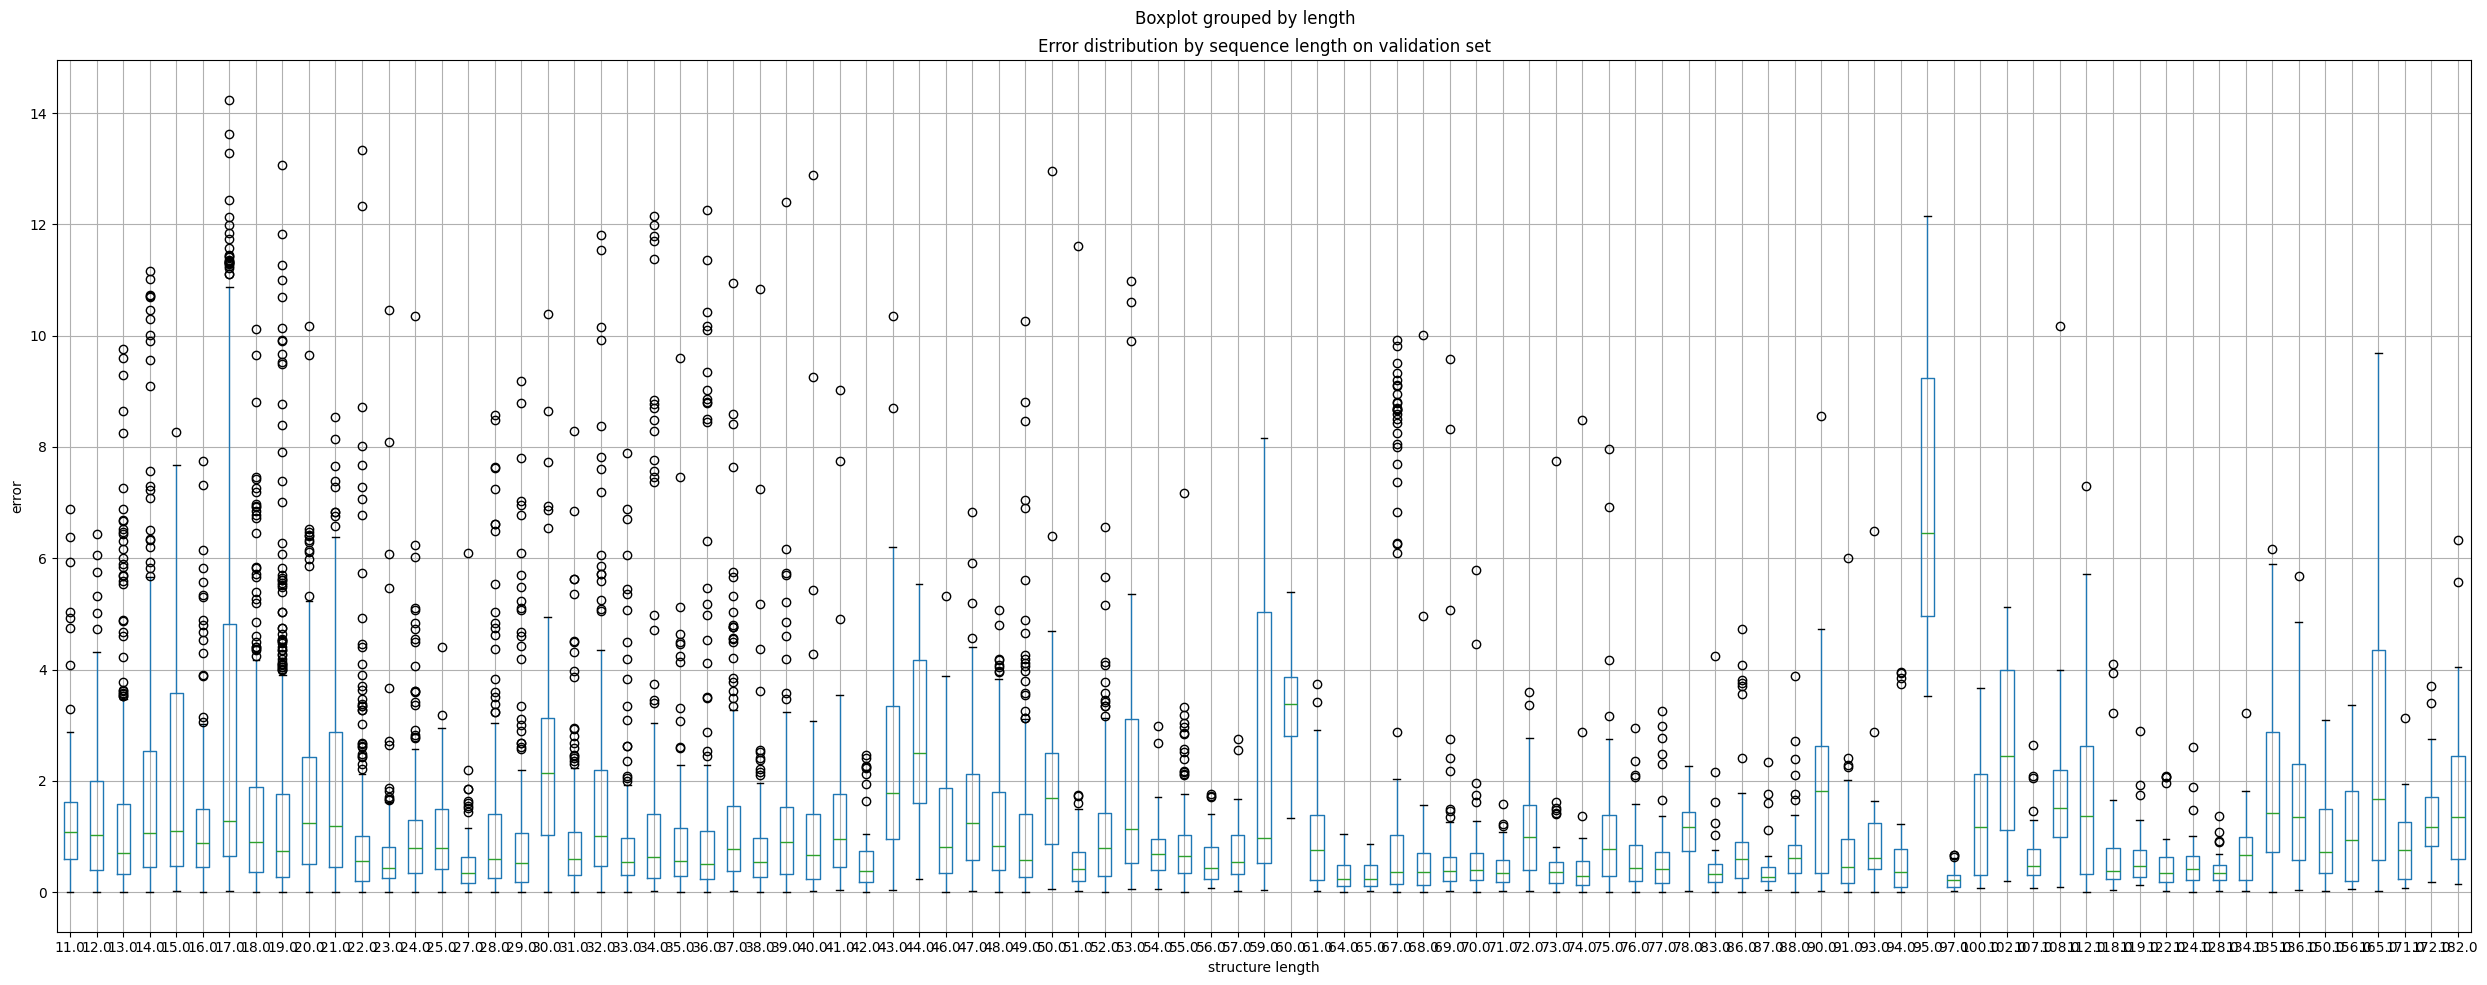

In [8]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val_model = RNAQuANet.load_from_checkpoint(
    '/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-lociparse_dataset__all/920236849910850327/d27427a3cab649fb836d3ca9620b46d0/checkpoints/epoch=27-step=8596.ckpt',
    number_of_node_features=dataset_train[0].x.shape[1],strict=False
)
val_model=val_model.eval()
res = []
for i in dataset_val:
    res.append(
        [
            i.x.shape[0],
            float(
                abs(
                    i.y.cpu()
                    - val_model(i.x.cuda(), i.edge_index.cuda(), i.edge_attr.cuda(), torch.zeros(i.x.shape[0],dtype=torch.int64).cuda()).detach().cpu().numpy()
                )
            ),
        ]
    )
df = pd.DataFrame(np.array(res), columns=["length", "error"])
fig, ax = plt.subplots(figsize=(25, 10))

df.boxplot(column="error", by="length", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("error")
ax.set_title("Error distribution by sequence length on validation set")
plt.tight_layout()
mlf_logger.experiment.log_figure(mlf_logger.run_id,fig, "error_distribution_by_length.svg")
mlf_logger.experiment.log_text(mlf_logger.run_id,str(val_model.eval()), "architecture.txt")
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").mean().plot(kind="bar", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("mean error")
ax.set_title("Mean error by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id,fig, "error_mean_by_length.svg")
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").count().plot(kind="bar", ax=ax)

ax.set_xlabel("structure length")
ax.set_ylabel("cardinality")
ax.set_title("Cardinality by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id, fig, "cardinality_by_length.svg")
plt.show()

mlf_logger.experiment.log_metric(mlf_logger.run_id,"best_val_loss_mae", model_checkpoint.best_model_score.cpu().tolist())
mlf_logger.experiment.log_metric(mlf_logger.run_id,"best_val_loss_mse", (df["error"]**2.0).mean())


In [10]:
model_checkpoint.best_model_path

'/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-lociparse_dataset__all/920236849910850327/333226a0193146909c189016a26e4127/checkpoints/epoch=45-step=15226.ckpt'

In [50]:
val_model = RNAQuANet.load_from_checkpoint(
'/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-ares_dataset__all/306037256498709437/907d0b5d821048268dfe231227affa42/checkpoints/epoch=11-step=672.ckpt',
    number_of_node_features=dataset_train[0].x.shape[1],strict=False
)
val_model.eval()
val_model._trainer = L.Trainer()
m=torch.jit.script(val_model).cuda()
torch.jit.save(m,f"/tmp/{mlf_logger.run_id}.pt")
mlf_logger.experiment.log_artifact(mlf_logger.run_id,
    f"/tmp/{mlf_logger.run_id}.pt",
    artifact_path="model"
)

mlflow.pytorch.log_model(mlf_logger.run_id, val_model, "models")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NotSupportedError: Compiled functions can't take variable number of arguments or use keyword-only arguments with defaults:
  File "/home/adamczykb/rnaquanet/.venv/lib/python3.13/site-packages/torch_geometric/nn/conv/message_passing.py", line 425
        edge_index: Adj,
        size: Size = None,
        **kwargs: Any,
         ~~~~~~~ <--- HERE
    ) -> Tensor:
        r"""The initial call to start propagating messages.


In [33]:
train_loader = DataLoader(dataset_train, num_workers=24, batch_size=125, shuffle=True)

